# Data Mining - Final Project - Team Supreme

## Predicting Customer churn for a Telecommunication Company

### Authored by:
Team Name: Team Supreme

Team Members: Arivarasan Ramasamy, Ganti Uday, Pushvanth Teja Malisetty, Nikhil Namani, Suraj Varma Dantuluri, Madhumitha Jeripothula 

### Introduction and Overview 

Customers churn is an everyday thing with telecom companies, although the percentage rate increased slightly following the pandemic. Our objective is in this project is to create a Machine Learning model that can predict weather a customer is likely to leave the telecom service or not’.

In this notebook we are training multiple ML models with customer data from IBM Business Analytics Community. These data sets have all been tested with IBM Cognos Analytics. 


### Business objective:

Our target is to predict whether a customer is likely to leave the telecom network or not. 

By comparing the best metrics from the diffrent ML models and coming up with recommendations for the Telecom companies to handle customer chrun issue.

In this context,

True Positives – Number of customers that the model correctly predicted will churn. *** 

False Positives - Number of customers the model predicted will churn but they didn’t. *

True Negatives - Number of customers whom the model correctly predicted will not churn* 

False Negatives - Number of customers that the model predicted will not churn but they did. ***


Our main focus will be TP and FN. Because, misscalculation in these metrics will result in a loss of a customer.(Which is the highest priority). Whereas, FP and TN, have not much impact on our business cost, Eventough, we take steps to make to retain the customer in FP and TN, it will be like a insentive to the existing customer. So  FP and TN will not have mmuch impact on our business model.
Our focus will be on model with best Recall score with accuracy as a next important metric to be considered.

Here, F-beta = 2 will be a important metric for this business case. 

### Install and import necessary packages

In [1]:
import pandas as pd
import numpy as np

#import dateutil.parser
#from datetime import date
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn import preprocessing 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, plot_roc_curve, roc_auc_score, roc_curve, auc, RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve,fbeta_score,make_scorer

from sklearn.metrics import roc_curve

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier

import seaborn as sns

random_seed = 1
np.random.seed(random_seed)

C:\Users\Uday Ganti\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Load and Explore data

In [2]:
customer_df = pd.read_csv("Churn.csv")
customer_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
customer_df.shape

(7043, 21)

The data file has 21 variables and 7043 observations.

In [4]:
customer_df.describe() 

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [5]:
customer_df['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

Let's visulaize the amount of data imbalance in our target variable. using Seaborn library

C:\Users\Uday Ganti\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Churn', ylabel='count'>

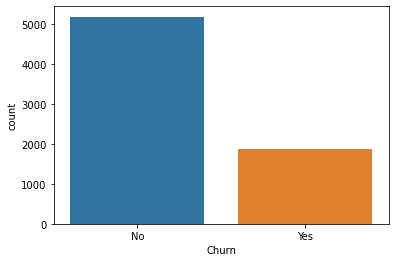

In [6]:
sns.countplot(customer_df.Churn)

### Rename Columns

Often times the column names can have blank spaces, or other issues. We often change column names because of this.

In [7]:
customer_df.columns = [s.strip().replace(' ', '_') for s in customer_df.columns]
customer_df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

### Drop any columns that are not interested in

Variables that are not contributing factors in predicting the Chrun of an customer are removed.
We can see that customerID is just a label to the customer, this is not a significant input variable to be considered for prediction.

In [8]:
customer_df = customer_df.drop('customerID', axis=1) # customerID is just a label, this is not a good parameter to be considered for predicting customer behaviour 

In [9]:
customer_df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

### Identify and Handle Any Missing Data
First, let's identify any columns that contain missing data...

In [10]:
customer_df.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

There is no null value, but there are some empty string values in the TotalCharges variable. Which we found out when converting the TotalCharges variable from object to float datatype. So, we are backtracking to fix the empty string values in TotalCharges variable.

In [11]:
customer_df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Since TotalCharges variable has empty strings and it is in Object data type. We are using regex patterns to find and replace empty string values with NaN as a part of data cleaning.

In [12]:
customer_df = customer_df.replace(r'^\s*$', np.nan, regex=True)

Identified TotalCharges as float value but its datatype is in object. Converting the datatype of TotalCharges to float64. Now calculating the number of null values.
We can see that there are 11 empty strings that are converted to null

In [13]:
customer_df.TotalCharges.isna().sum()

11

In [14]:
customer_df["TotalCharges"] = pd.to_numeric(customer_df["TotalCharges"])

### Imputing missing values with mean

In [15]:
mean_TotalCharges = customer_df['TotalCharges'].mean()

customer_df.TotalCharges = customer_df.TotalCharges.fillna(value=mean_TotalCharges)

Contract variable contains ordinal value, so converting it to values of int64 datatype by the number of months.

## Relationship between Gender and Churn

C:\Users\Uday Ganti\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Churn', ylabel='count'>

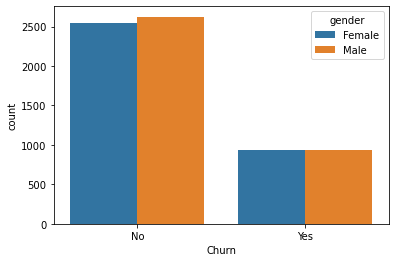

In [16]:
sns.countplot("Churn", data=customer_df,hue="gender")

It is apparent from the graph above that 'gender' is not a significant contributing factor for churn.

Information like this is helpful to marketing and advertizing teams of this company as it will provide a target demographic they can focus on.

## Relationship between Contract Duration and Churn

C:\Users\Uday Ganti\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Churn', ylabel='count'>

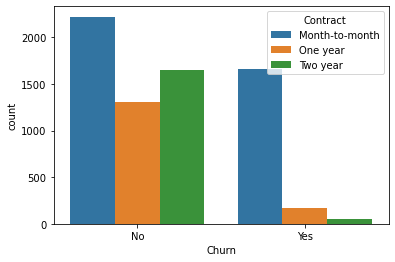

In [17]:
sns.countplot("Churn", data=customer_df,hue="Contract")

Customers with longer contracts tend to churn less.

This kind of information can help marketing teams identify the products that need to be pushed to a higher degree. Insentives should be provided to make customers select longer contracts over short ones.

## Relationship between Internet Service and Churn

C:\Users\Uday Ganti\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Churn', ylabel='count'>

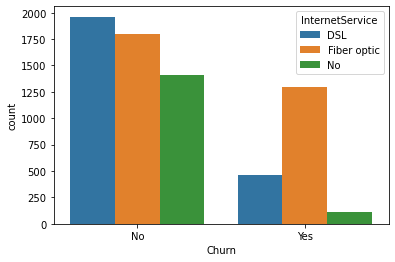

In [18]:
sns.countplot("Churn", data=customer_df,hue=("InternetService"))

Customers who have opted for 'fiber optic' internet service are more likely to churn. 

This information helps leadership identify which division of the company is underperforming and propose changes to fix the problems that are causing the dip in performance.

## Relationship between being a Senior Citizen and Churn

Text(0.5, 1.0, '% of Senior Citizen')

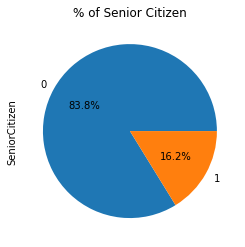

In [19]:
customer_df['SeniorCitizen'].value_counts().plot.pie(autopct='%1.1f%%');
plt.title("% of Senior Citizen")

While looking into who the most loyal customers will be, if you look at this graph, you might believe that senior citizens are most likely to stay loyal. So, focusing on marketing campaigns for senior citizens whould be the obvious step to take.

In this case, however, industry knowledge proves to be more relevant than data. Senior Citizins have their mobile plans picked by younger people. So targeting them with benefits pertaining to 'family plans' might be a better apporch to gain more profit in this case.

## Relationship between TechSupport and Churn

C:\Users\Uday Ganti\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Churn', ylabel='count'>

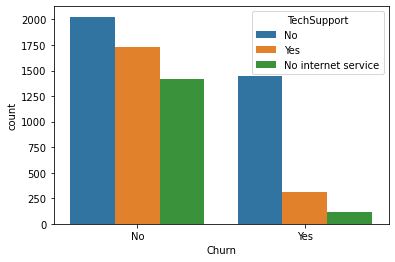

In [20]:
sns.countplot("Churn", data=customer_df,hue=customer_df["TechSupport"])

Data like this can also be used as proof of concept for future ideas.

For example, in the above data, we can see that customers who opted for tech support are significantly less likely to churn. This serves as proof that "fixing customer problems by approchinng them proactively" will lead to greater customer retention.

### Encoding input and output variables

#### encoding input ordinal variables

In [21]:
customer_df['Contract'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

We see that that the contract variable is in string object, having ordinal value. This can be encoded as ordinal value. For better clarification and to avoid using fractional numbers for month, I convert all values to its equivaluent number of months

In [22]:
scale_contract = {'Month-to-month':1, 'One year': 12, 'Two year':24}
customer_df['Contract'] = customer_df['Contract'].replace(scale_contract)
customer_df["Contract"] = pd.to_numeric(customer_df["Contract"])

#### Output variables are encoded with Label encoder

In [23]:
le = LabelEncoder()
customer_df['Churn'] = le.fit_transform(customer_df['Churn'])

### Identify and convert any categorical data

Indentifying the categorical variables

In [24]:
customer_df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract              int64
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int32
dtype: object

Verifying some of the categorical variable values and identifying them for dummy encoding or ordinal encoding.

In [25]:
customer_df.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,1,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,12,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,1,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,12,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,1,Yes,Electronic check,70.70,151.65,1


#### Dummy encoding for input categorical variables.

Converting categorical variable datatype from objec to category for dummy encoding.

In [26]:
customer_df.gender = customer_df.gender.astype('category')
customer_df.Partner = customer_df.Partner.astype('category')
customer_df.Dependents = customer_df.Dependents.astype('category')
customer_df.PhoneService = customer_df.PhoneService.astype('category')
customer_df.MultipleLines = customer_df.MultipleLines.astype('category')
customer_df.InternetService = customer_df.InternetService.astype('category')
customer_df.OnlineSecurity = customer_df.OnlineSecurity.astype('category')
customer_df.OnlineBackup = customer_df.OnlineBackup.astype('category')
customer_df.DeviceProtection = customer_df.DeviceProtection.astype('category')
customer_df.TechSupport = customer_df.TechSupport.astype('category')
customer_df.StreamingTV = customer_df.StreamingTV.astype('category')
customer_df.StreamingMovies = customer_df.StreamingMovies.astype('category')
customer_df.PaperlessBilling = customer_df.PaperlessBilling.astype('category')
customer_df.PaymentMethod = customer_df.PaymentMethod.astype('category')

In [27]:
customer_df = pd.get_dummies(customer_df, prefix_sep='_', drop_first=True)
customer_df.columns

Index(['SeniorCitizen', 'tenure', 'Contract', 'MonthlyCharges', 'TotalCharges',
       'Churn', 'gender_Male', 'Partner_Yes', 'Dependents_Yes',
       'PhoneService_Yes', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No internet service',
       'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [28]:
customer_df.head()

,SeniorCitizen,tenure,Contract,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,...,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,1,29.85,29.85,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
1,0,34,12,56.95,1889.50,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0,2,1,53.85,108.15,1,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
3,0,45,12,42.30,1840.75,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,2,1,70.70,151.65,1,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0


### Spliting dataset into train and test data

Spliting dataset in the ratio of 70:30 

Where 70% of the entire data is used for training and rest 30% data is used for testing the trained model.
which we can analyse the performance of models by comparing the diffrent scoring metrics with the predicted target value and the actual test value. 

In [29]:
# split the data into validation and training set
train_df, validation_df = train_test_split(customer_df, test_size=0.3, random_state=1)
train_df.shape

(4930, 30)

In [30]:
# construct datasets for analysis
target = 'Churn'
predictors = list(customer_df.columns)
predictors.remove(target)

In [31]:
train_df['Churn'].value_counts()

0    3589
1    1341
Name: Churn, dtype: int64

### Data Balancing- Random Over sampling

As we can see the data is imbalanced, this may cause the result metrics to be biased with the majority sample side.

We see that the data set is of less number around 4930 rows for training data. Choosing Undersampling will further reduce the amount of training data, so we are planing to go with oversampling.

In [32]:
# "oversampling"

train_df_will_leave = train_df[train_df['Churn'] == 1]
train_df_will_not_leave = train_df[train_df['Churn'] == 0]

diffrence_in_samples = len(train_df_will_not_leave) - len(train_df_will_leave)

random_sample_train_df_will_leave = train_df_will_leave.sample(diffrence_in_samples, replace=True)
train_df_will_leave = pd.concat([train_df_will_leave,random_sample_train_df_will_leave])

train_df = pd.concat([train_df_will_not_leave,train_df_will_leave])

Re-checking for the balanced data

In [33]:
train_df['Churn'].value_counts()

0    3589
1    3589
Name: Churn, dtype: int64

### Normalise and transform predictors

This dataset has values in diffrent ranges. Some models may be sensitive to diffrent in scales, So Scaling the training and validation data seperatly, Because if we do normalization before spliting, there is a possiblities of data lekage. Reference  [Link1](https://community.rapidminer.com/discussion/32592/normalising-data-before-data-split-or-after),
 [Link 2](https://datascience.stackexchange.com/questions/54908/data-normalization-before-or-after-train-test-split)

In [34]:
# create a standard scaler and fit it to the training set of predictors
scaler = preprocessing.StandardScaler()
scaler.fit(train_df[predictors])

# Transform the predictors of training and validation sets
train_predictors = scaler.transform(train_df[predictors]) # train_predictors is not a numpy array
train_target = train_df[target] # train_target is now a series object

validation_predictors = scaler.transform(validation_df[predictors]) # validation_target is now a series object
validation_target = validation_df[target] # validation_target is now a series object

### Model-1: K-NN model with hyperparameter tuning and K-fold cross validation

In [35]:
%%time
score_measure = 'recall'
k_fold = 10
# Start with an initial guess for parameters
param_grid = {
    'n_neighbors': list(range(1,(71*2),2)),
    'metric': ['euclidean', 'cosine']
}
gridSearchBestKnn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=k_fold, scoring=score_measure,
                          n_jobs=-1)  # n_jobs=-1 will utilize all available CPUs 
gridSearchBestKnn.fit(train_predictors, train_target)
y_pred = gridSearchBestKnn.predict(validation_predictors)
print(score_measure, 'score: ', gridSearchBestKnn.best_score_)
print(f"{'Accuracy Score: ':18}{accuracy_score(validation_target, y_pred):.3f}")
print('parameters: ', gridSearchBestKnn.best_params_)

bestRecallKnn = gridSearchBestKnn.best_estimator_


recall score:  0.9582141578873656
Accuracy Score:   0.719
parameters:  {'metric': 'euclidean', 'n_neighbors': 1}
CPU times: total: 5.17 s
Wall time: 38.4 s


In [36]:
confusion_matrix(validation_target, y_pred)

array([[1249,  336],
       [ 258,  270]], dtype=int64)

### Model 2: Decision Tree with hyperparameter tuning and K-fold cross validation

In [37]:
%%time
score_measure = 'recall'
k_fold = 10
# Start with an initial guess for parameters
param_grid = {
    'max_depth': [10, 20, 30, 40], 
    'min_samples_split': [2, 5, 10, 20, 40], 
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01], 
}
gridSearchBestDT = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=k_fold, scoring=score_measure,
                          n_jobs=-1)  # n_jobs=-1 will utilize all available CPUs 
gridSearchBestDT.fit(train_predictors, train_target)
y_pred = gridSearchBestDT.predict(validation_predictors)
print(score_measure, 'score: ', gridSearchBestDT.best_score_)
print(f"{'Accuracy Score: ':18}{accuracy_score(validation_target, y_pred):.3f}")
print('parameters: ', gridSearchBestDT.best_params_)

recall score:  0.9640652962138777
Accuracy Score:   0.732
parameters:  {'max_depth': 30, 'min_impurity_decrease': 0, 'min_samples_split': 2}
CPU times: total: 906 ms
Wall time: 2.87 s


In [38]:
DT_confusion_matrix = confusion_matrix(validation_target, y_pred)
DT_confusion_matrix

array([[1288,  297],
       [ 269,  259]], dtype=int64)

### Model 3: Random Forest with hyperparameter tuning and K-fold cross validation

In [39]:
%%time
score_measure = 'recall'
k_fold = 10
param_grid = {
    'max_depth': [2,5,3,4,7,8], 
    'min_samples_split': [20,30, 40,50, 60], 
    'min_impurity_decrease': [ 0.001, 0.0005, 0.0007,0.0003], 
}
gridSearchRF = GridSearchCV(RandomForestClassifier(random_state=random_seed), param_grid, cv=k_fold, scoring=score_measure,
                          n_jobs=-1)

gridSearchRF.fit(train_predictors, train_target)
y_pred = gridSearchRF.predict(validation_predictors)
print(score_measure, 'score: ', gridSearchRF.best_score_)
print(f"{'Accuracy Score: ':18}{accuracy_score(validation_target, y_pred):.3f}")
print('parameters: ', gridSearchRF.best_params_)

recall score:  0.8255699413330013
Accuracy Score:   0.752
parameters:  {'max_depth': 5, 'min_impurity_decrease': 0.0003, 'min_samples_split': 50}
CPU times: total: 5.88 s
Wall time: 54.7 s


### Model 4: AdaBoost with hyperparameter tuning and K-fold cross validation

In [40]:
%%time
score_measure = 'recall'
k_fold = 10
param_grid = { 
              'n_estimators':[5,20,50,100],
              }

gridSearchADA = GridSearchCV(AdaBoostClassifier(random_state=random_seed), param_grid, cv=k_fold, scoring=score_measure,
                          n_jobs=-1)
gridSearchADA.fit(train_predictors, train_target)
y_pred = gridSearchADA.predict(validation_predictors)
print(score_measure, 'score: ', gridSearchADA.best_score_)
print(f"{'Accuracy Score: ':18}{accuracy_score(validation_target, y_pred):.3f}")
print('parameters: ', gridSearchADA.best_params_)

recall score:  0.8258516051726552
Accuracy Score:   0.749
parameters:  {'n_estimators': 100}
CPU times: total: 516 ms
Wall time: 2.32 s


### Model 5: GradientBoosting Classifier with hyperparameter tuning and kfold cross validation

In [41]:
%%time
score_measure = 'recall'
k_fold = 10
param_grid = {
    'n_estimators': (2,3,5),
    'learning_rate': (0.1,0.2,0.3,0.4,0.5)
}
gridSearchGB = GridSearchCV(GradientBoostingClassifier(random_state=random_seed), param_grid, cv=k_fold, scoring=score_measure,
                          n_jobs=-1)
gridSearchGB.fit(train_predictors, train_target)
y_pred = gridSearchGB.predict(validation_predictors)
print(score_measure, 'score: ', gridSearchGB.best_score_)
print(f"{'Accuracy Score: ':18}{accuracy_score(validation_target, y_pred):.3f}")
print('parameters: ', gridSearchGB.best_params_)

recall score:  0.8319781827235804
Accuracy Score:   0.733
parameters:  {'learning_rate': 0.4, 'n_estimators': 3}
CPU times: total: 438 ms
Wall time: 931 ms


### Model 6: XGBoost with hyperparameter tuning and kfold cross validation

In [42]:
%%time
score_measure = 'recall'
k_fold = 10
param_grid = {
    'max_depth': (1,2,3),
    'max_leaves': (1,2,3),
    'learning_rate': (0.1,0.15),
}
gridSearchXGB = GridSearchCV(XGBClassifier(random_state=random_seed, use_label_encoder = False, eval_metric='mlogloss'), param_grid, cv=k_fold, scoring=score_measure,
                          n_jobs=-1)
gridSearchXGB.fit(train_predictors, train_target)
y_pred = gridSearchXGB.predict(validation_predictors)
print(score_measure, 'score: ', gridSearchXGB.best_score_)
print(f"{'Accuracy Score: ':18}{accuracy_score(validation_target, y_pred):.3f}")
print('parameters: ', gridSearchXGB.best_params_)

recall score:  0.8392251910178802
Accuracy Score:   0.756
parameters:  {'learning_rate': 0.15, 'max_depth': 3, 'max_leaves': 1}
CPU times: total: 2.95 s
Wall time: 13.8 s


### Model 7: Logistic regression with hyperpareter tuning and k-fold cross validating

In [43]:

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [10, 1.0, 0.1]
ftwo_scorer = make_scorer(fbeta_score, beta =2)
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values, max_iter=[50000])
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

best_logClassifer = GridSearchCV(estimator=LogisticRegression(random_state=1), param_grid=grid, n_jobs=-1, scoring=ftwo_scorer,error_score=0)

#best_logClassifer = GridSearchCV(estimator=LogisticRegression(random_state=1),scoring='recall', param_grid=param_grid, cv=10, verbose=0,  n_jobs = -1)
best_logClassifer.fit(train_predictors, train_target)

y_pred = best_logClassifer.predict(validation_predictors)
print(score_measure, 'score: ', best_logClassifer.best_score_)
print(f"{'Accuracy Score: ':18}{accuracy_score(validation_target, y_pred):.3f}")
print('parameters: ', best_logClassifer.best_params_)

tps = []
fps = []
tns = []
fns = []  
precs = []
recls = []

tprs = []
fprs = []
thres = []
for threshold in np.arange(0.1, 0.9, 0.1):
    y_pred= best_logClassifer.predict_proba(validation_predictors)[:,1]>=threshold
    m = confusion_matrix(validation_target, y_pred)
    TP = m[1,1]
    TN = m[0,0]
    FP = m[0,1]
    FN = m[1,0]
    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)
    recall = TP / (TP+FN)
    precision = TP / (TP+FP)
    tps.append(TP)
    fps.append(FP)
    tns.append(TN)
    fns.append(FN)
    tprs.append(TPR)
    fprs.append(FPR)
    recls.append(recall)
    precs.append(precision)
    thres.append(str(round(threshold,2)))

print(validation_target.value_counts())
df = pd.DataFrame(list(zip(thres, tps, fps, tns, fns, fprs, tprs, precs, recls)), columns=['Threshold', 'TP', 'FP', 'TN', 'FN', 'FPR', 'TPR', 'Precision', 'Recall'])
df

recall score:  0.7905820826597499
Accuracy Score:   0.755
parameters:  {'C': 10, 'max_iter': 50000, 'penalty': 'l2', 'solver': 'newton-cg'}
0    1585
1     528
Name: Churn, dtype: int64


,Threshold,TP,FP,TN,FN,FPR,TPR,Precision,Recall
0,0.1,519,1104,481,9,0.696530,0.982955,0.319778,0.982955
1,0.2,508,839,746,20,0.529338,0.962121,0.377134,0.962121
2,0.3,500,690,895,28,0.435331,0.946970,0.420168,0.946970
3,0.4,479,564,1021,49,0.355836,0.907197,0.459252,0.907197
4,0.5,438,427,1158,90,0.269401,0.829545,0.506358,0.829545
5,0.6,391,334,1251,137,0.210726,0.740530,0.539310,0.740530
6,0.7,324,211,1374,204,0.133123,0.613636,0.605607,0.613636
7,0.8,203,87,1498,325,0.054890,0.384470,0.700000,0.384470


### ROC AUC

We are trying to plot the ROC curve for diffrent threshold values for the logistic regression model that we fit above. From the ROC curv we are trying to compare the Change of True Positive Rate with respect to decrese in False Positive Rate.
This will give us a good picture of how well the model predicts the chrun of a customer at diffrent threshold.

We are using SKLearn direct function to construct the ROC curve

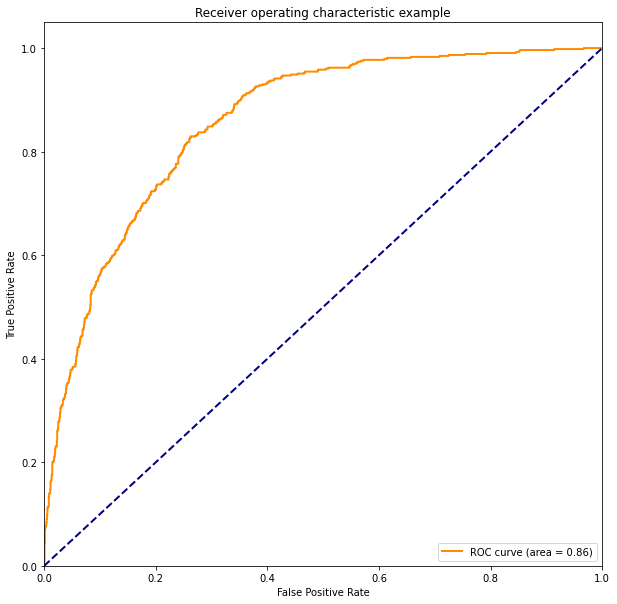

In [44]:
# compute tpr and fpr for for different thresholds
fpr, tpr, thresholds = roc_curve(validation_target, best_logClassifer.predict_proba(validation_predictors)[:,1])

# compute roc auc
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

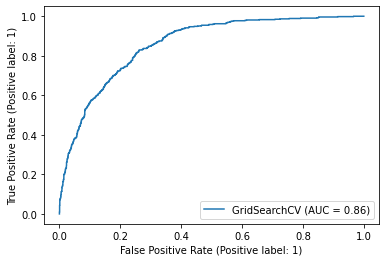

In [45]:
RocCurveDisplay.from_estimator(best_logClassifer, validation_predictors, validation_target)
plt.show()

From the graph, we can infer that Area Under the Curve(AUC) is having a large value, this shows the Logistic Regression model performs well in predicting churn, but this is not the best model among all the above we tried,  Where Decission Tree has high recall score with precission.

### PR AUC

From this PR AUC chart we are trying to compare the precision and recall value to find the best threshold value for the logistic regression model that we fit in above

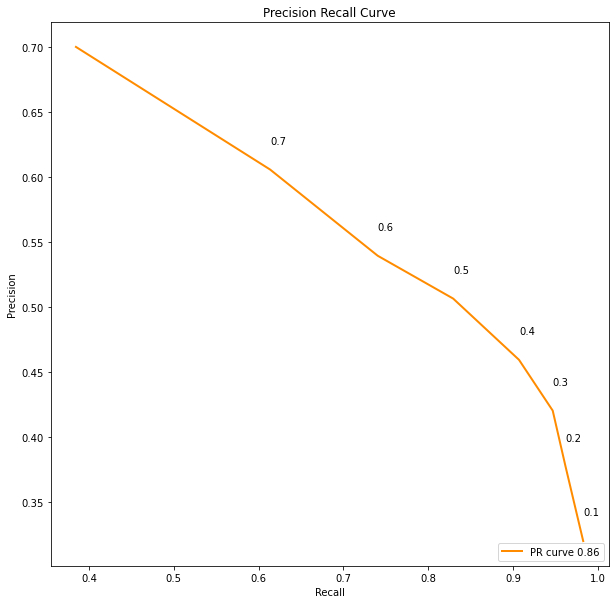

In [46]:
# compute pr auc
pr_auc = auc(recls, precs)

plt.figure(figsize=(10,10))
plt.plot(recls, precs, color='darkorange', lw=2, label=f'PR curve {roc_auc:.2f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.legend(loc="lower right")

for i in range(len(tprs)):
    plt.annotate(thres[i], (recls[i], precs[i] + 0.02))
    

From the above PR curve, we can see the maximum recall value with a good precission is at a thershold value of 0.8 

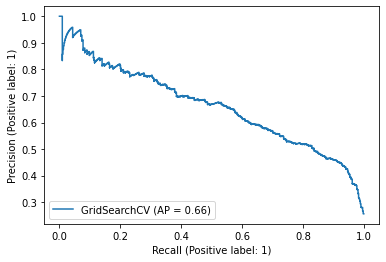

In [47]:
PrecisionRecallDisplay.from_estimator(best_logClassifer, validation_predictors, validation_target) 
plt.show()

### Model 8: Neural Network with hyperparameter tuning

In [48]:
score_measure = 'recall'
param_grid = {
    'activation': ['identity','logistic','tanh','relu'],
    'solver': ['sgd','adam']
}
gridSearchAnn = GridSearchCV(MLPClassifier(hidden_layer_sizes=(16,8,4), max_iter=20000), param_grid, scoring=score_measure, n_jobs=-1)

gridSearchAnn.fit(train_predictors, train_target)

y_pred = gridSearchAnn.predict(validation_predictors)
print(score_measure, 'score: ', gridSearchAnn.best_score_)
print(f"{'Accuracy Score: ':18}{accuracy_score(validation_target, y_pred):.3f}")
print('parameters: ', gridSearchAnn.best_params_)

recall score:  0.8737870187993148
Accuracy Score:   0.726
parameters:  {'activation': 'tanh', 'solver': 'adam'}


In [49]:
confusion_matrix(validation_target, y_pred)

array([[1165,  420],
       [ 159,  369]], dtype=int64)

### Metrics comparision and best model for our project
We trained 8 diffrent models and compared the results of Recall and Precision from which
Decision Tree with hyper parameter tuning and K-fold cross validation gave the highest recall score of 96.40% with a accuracy of  accuracy 73.20%

Whereas, highest accuracy is achieved in Artificial Neural Networks with a maximum of 78.40% but it has less recall score than Decisssion tree.

| Model | Recall | Accuracy |
| --- | --- | --- |
| KNN         | 95.82% | 71.90% |
| Decision Tree   | 96.40% | 73.20% |
| Random Forest   | 82.55% | 75.20% |
| AdaBoost   | 82.58% | 74.90% |
| Gradient Boosting | 83.19% | 73.30% |
| XGBoost | 83.19% | 75.60% |
| Logistic Regression | 79.05% | 75.50% |
| Neural Network | 87.37% | 72.60% |

Recall score - The number of correct positive predictions made out of all positive predictions that could have been made. This is the important metric to find the customer churn or not. Because based on this number we are going to spend money on business campaign. 
Our best model for recall is Decission Tree.

In [50]:
DT_confusion_matrix

array([[1288,  297],
       [ 269,  259]], dtype=int64)

In [51]:
TP = DT_confusion_matrix[1, 1] # True Positives
TN = DT_confusion_matrix[0, 0] # True Negatives
FP = DT_confusion_matrix[0, 1] # False Positives
FN = DT_confusion_matrix[1, 0] # False Negatives

Total_test_samples = TP+TN+FP+FN
Total_test_samples

2113

From the Above confusion matrix we can see that True Negative is having high value ,i.e Number of customers whom the model correctly predicted will not churn. 

This is because the base dataset is having more entries for customers will not churn. We did data balancing only for train set not for the test set. Eventhough, our model correctly predicted the majority value of TP correctly. This is a good sign that our model performs well with the test set.


True Negative = 1288. Out of 2113 test data our model predicted correctly that 1288 customers will not chrun. 
This information is useful to find the satisfied customers.
Also, this data can be used to exclude these 1288 customers when there is a campaign to target only unsatisfied customers.


True Positive  = 259 (i.e Number of customers that the model correctly predicted will churn) We need to focus on these customers to check for any service improvements to make them retain in the network. These are the customers we need to target to retain.

False Positive = 297. Number of customer our model predicted that they will churn but they did not. This is not a major issue because we will target these customers to retain but they are aldready satisfied customers. We may spend money to retain them but that will not be a big loss as it can be considered as in insentive to the existing customer. Also this percent much is less compared to the True Negative. So we will add only more extra customers to target this will not make more loss to our campaign.

False Negative = 269. The number of customers that the model predicted will not churn but they did. This are customers we are going to miss. We need to improve models to reduce this value. 
These customers will churn also we dont know that they are going to churn from the service. This will be the major loss for the business. But are trying to reduce this number as low as we can. This value is also a small ratio compared to the overall data count.  

### Conclusion and Business recommendation:

In real world senario, there will be only two cases:

1 - Customer will churn

2 - Customer will not chur.

From this model we can find the customers who will not churn and exclude them from target campaignins, by doing so we can reduce the money spend on campaigain.
Also, target the model predicted churn customers and check feedback to improve the service to make them retain in the service.